# Project: 车道线标定

*English writeup is in writeup.pdf (generate by markdown)*

基本流程:

step1: 相机标定与图片扭曲纠正

step2: 图片透视变换

step3: 车道线图像处理

step4: 提取车道线（多项式拟合）

step5: 标记行车区域

step6: 流处理标记行车视频

In [1]:
import matplotlib.pyplot as plt

def Plot2Imgs(img, imged, is_cv =True, msg = "Changed Image"):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    f.tight_layout()
    if is_cv:
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(imged, cv2.COLOR_BGR2RGB))
    else:
        ax1.imshow(img)
        ax2.imshow(imged, cmap='gray')
    ax1.set_title('Original Image', fontsize=15)
    ax2.set_title(msg, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

## Step 1 相机标定与图片扭曲纠正
**source file: camera_cal.ipynb**

生成文件在camera_cal文件夹内

## Step 2 透视变换 
**source file: imgs_transf.py**

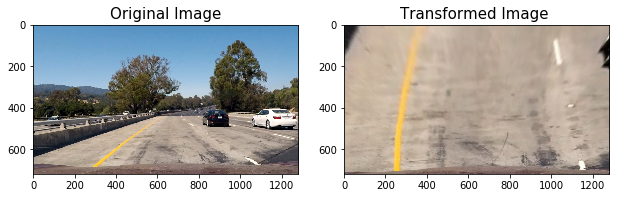

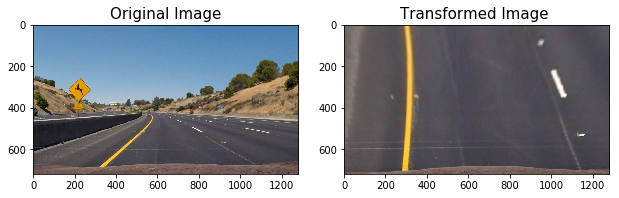

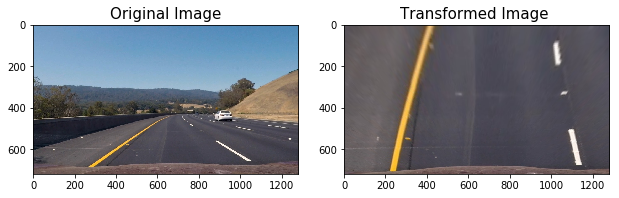

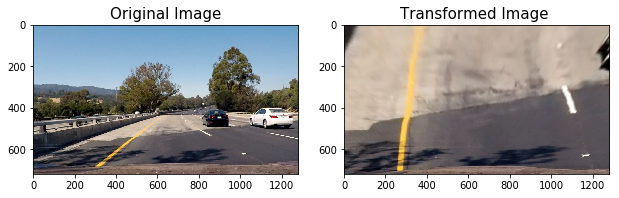

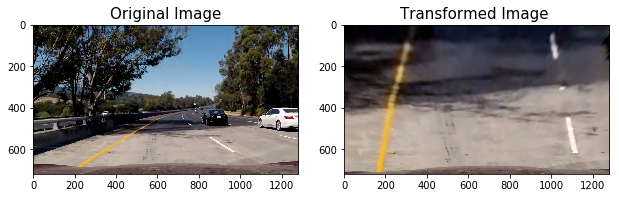

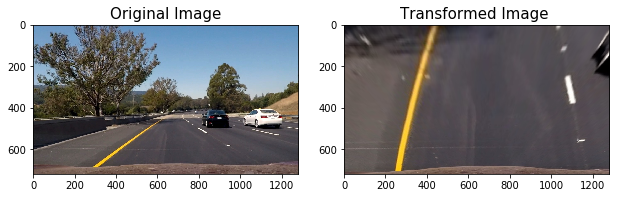

In [2]:
from imgs_transf import Undistort, PerspectiveTransform
# import glob
import cv2

# cause IO limit of jupyter, just show two cases of perspective transform 
for i in range(1,7):
    img_name = 'test_images/test'+str(i)+'.jpg'
    img = cv2.imread(img_name)
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    Plot2Imgs(img, warped, msg="Transformed Image ")

## Step 3 车道线图像处理（阈值处理）
**source file: imgs_pipeline.py**

最麻烦的一部分工作

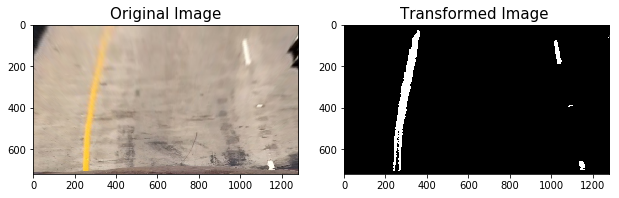

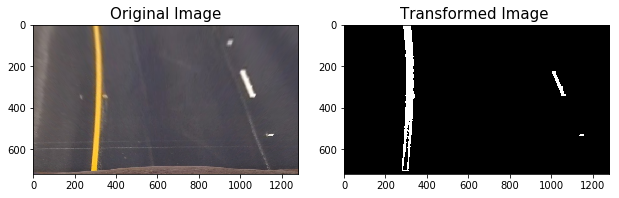

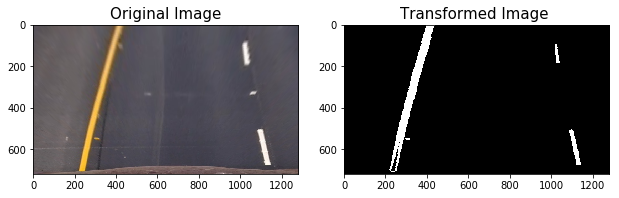

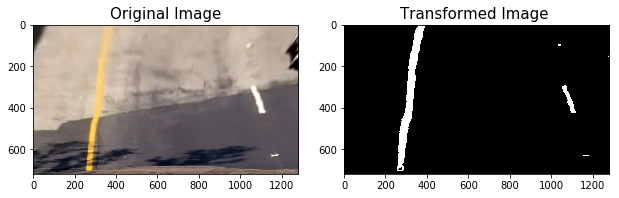

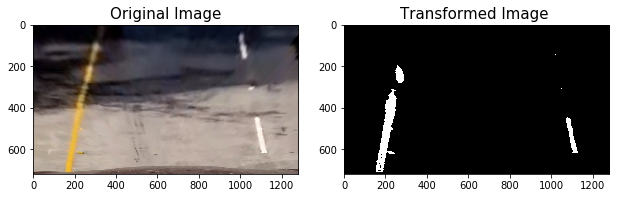

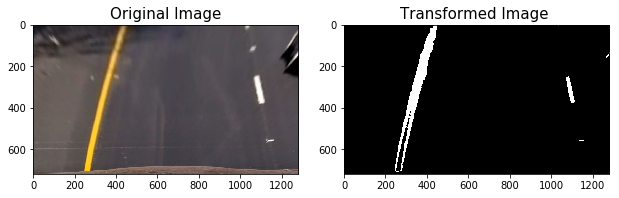

In [3]:
from imgs_processing import Processing
import matplotlib.image as mpimg

for i in range(1,7):
    img_name = 'test_images/test'+str(i)+'.jpg'
    img = mpimg.imread(img_name)
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    imged = Processing(warped)
    Plot2Imgs(warped, imged, is_cv=False, msg="Transformed Image ")

## Step 4 提取车道线
**source file: lines_finding.py**

在视频的初始部分使用窗口搜索

后面车道线固定后基于窗口搜索的结果的点上直接插值，可节省计算资源

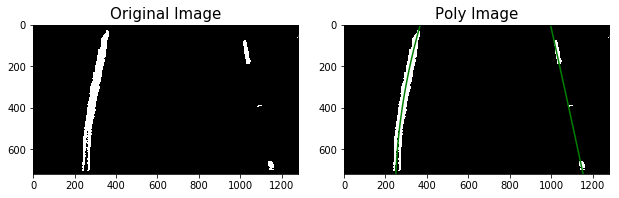

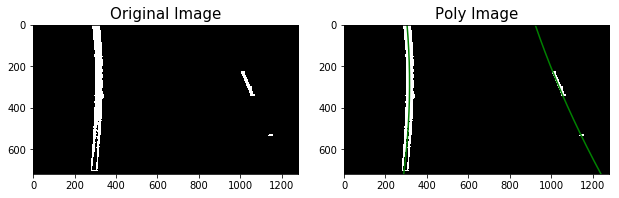

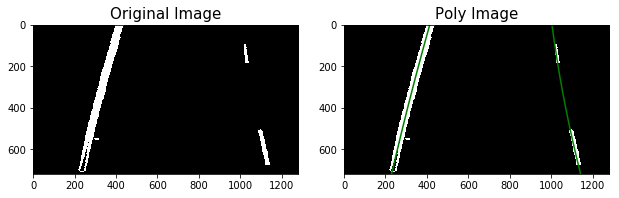

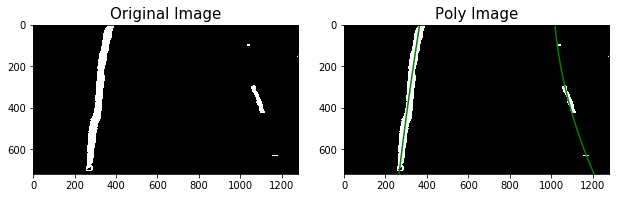

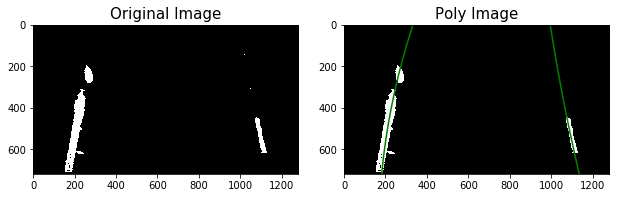

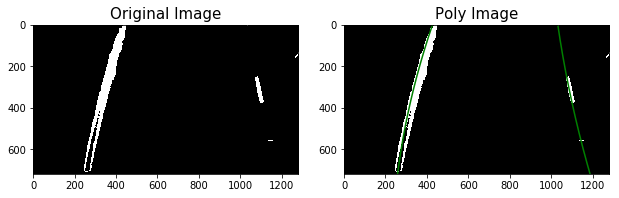

In [4]:
from lines_finding import LinesFinding

line = LinesFinding()
for i in range(1,7):
    img_name = 'test_images/test'+str(i)+'.jpg'
    img = mpimg.imread(img_name)
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    bin_warped = Processing(warped)
    if not line.is_found:
        line.window_search(bin_warped)
    else:
        line.direct_search(bin_warped)
    line.visual(bin_warped)

## Step 5 标记行车区域
将得到的直线覆盖至原图

**source file: imgs_drawing.py**

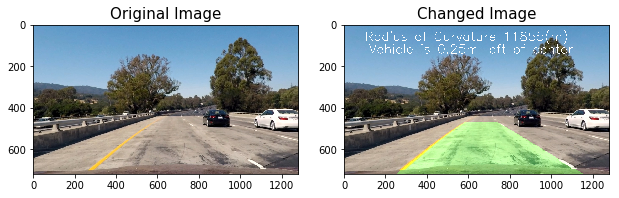

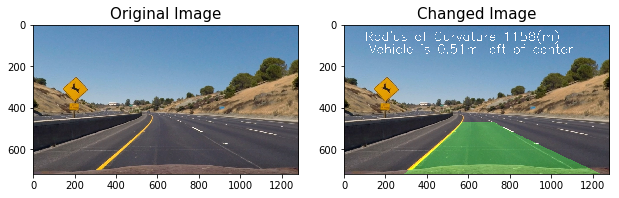

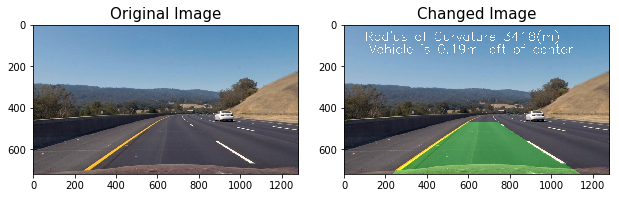

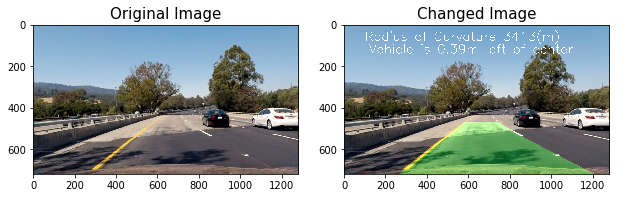

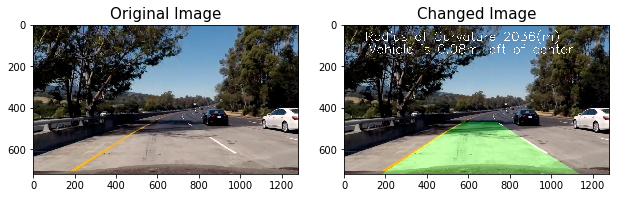

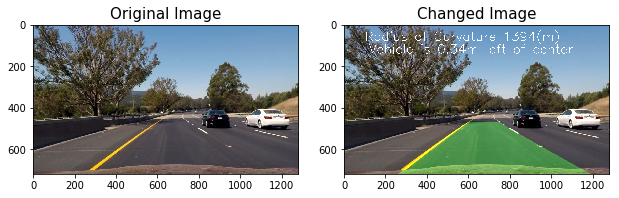

In [5]:
from imgs_drawing import Drawing

line = LinesFinding()
for i in range(1,7):
    img_name = 'test_images/test'+str(i)+'.jpg'
    img = mpimg.imread(img_name)
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    bin_warped = Processing(warped)
    if not line.is_found:
        line.window_search(bin_warped)
    else:
        line.direct_search(bin_warped)
    ploty = line.ploty
    leftx = line.left_fitx
    rightx = line.right_fitx
    curve_rad = line.curve_rad
    position = line.position 
    result = Drawing(undist, bin_warped, leftx, rightx, ploty, curve_rad, position)
    Plot2Imgs(undist, result, is_cv=False)

## Step 6 流处理标记行车视频

In [6]:
#------------------------------------for simper reload jupyter notebook----------------------
# from imgs_transf import Undistort, PerspectiveTransform
# # import glob
# import cv2
# from imgs_processing import Processing
# import matplotlib.image as mpimg
# from lines_finding import LinesFinding
# from imgs_drawing import Drawing
#-------------------------------------------------------------------------

line = LinesFinding()

def Pipeline(img):
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    bin_warped = Processing(warped)
    
    if not line.is_found:
        line.window_search(bin_warped)
    else:
        line.direct_search(bin_warped)
    ploty = line.ploty
    leftx = line.left_fitx
    rightx = line.right_fitx
    curve_rad = line.curve_rad
    position = line.position 
    result = Drawing(undist, bin_warped, leftx, rightx, ploty, curve_rad, position)
    return result

**在windows 平台下要注意两点**

* ffmpeg的版本，确定是稳定版 有时候其他软件会自带ffmpeg使得VideoFileClip这一步会出现OSError ffmpeg无法读取第一帧的错误
* 写入视频时要以管理员方式运行jupyter notebook，否则会出现 OSError: [WinError 6] 句柄无效。的错误 （这个看人品，经常出现，，，）

In [8]:
from moviepy.editor import VideoFileClip
output_video = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(Pipeline) 
write_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:58<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

